In [1]:
import numpy as np
from interface import ExoSkeletonUDPInterface
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import pickle as pkl

import time

import vicon_sdk_cpp
from vicon_sdk_cpp import ViconClient, ViconFrame
from interface import ExoSkeletonUDPInterface


In [2]:
# Connect to the server using a ViconClient.
client = ViconClient()
client.initialize("172.24.117.119:801")
client.run()

# Create a frame to hold the received data.
base_frame = ViconFrame()
shoulder_frame = ViconFrame()

Connecting to Vicon 172.24.117.119:801... 
Connected to Vicon System.
Warning this thread is not going to be real time.


In [3]:
interface = ExoSkeletonUDPInterface()
interface.calibrate()

calibration ...
setting offset ...
finished calibration ...


In [4]:
data_fk = []
data_angle = []
while True :
    interface.setCommand([0], [0.], [0], [0], [1.5])
    time.sleep(0.01)
    state = interface.getState()
    client.get_vicon_frame("EXO_BASE/EXO_BASE", base_frame)
    client.get_vicon_frame("EXO_ARM/EXO_ARM", shoulder_frame)
    shoulder_r = Rotation.from_quat(shoulder_frame.se3_pose[3:]).as_matrix()
    base_r = Rotation.from_quat(base_frame.se3_pose[3:]).as_matrix()
    error = Rotation.from_matrix(base_r.T @ shoulder_r)
    angle = np.linalg.norm(error.as_rotvec())
    data_angle.append(state["q"]) 
    data_fk.append(angle)

KeyboardInterrupt: 

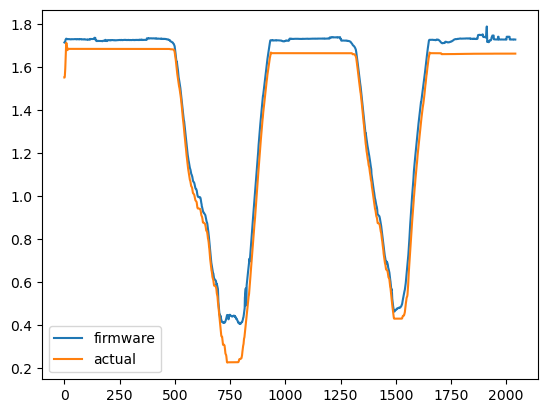

In [8]:
# plt.plot(data_fk, label = "firmware")
# plt.plot(data_angle, label = "actual")
# plt.legend()
# plt.show()

In [4]:
data_q = []
data_base = []
data_shoulder = []
T = 2000

for i in range(T):
    interface.setCommand([0], [0.], [0], [0], [1.5])
    time.sleep(0.01)
    client.get_vicon_frame("EXO_BASE/EXO_BASE", base_frame)
    data_base.append(base_frame.se3_pose[3:].copy())
    client.get_vicon_frame("EXO_ARM/EXO_ARM", shoulder_frame)
    data_shoulder.append(shoulder_frame.se3_pose[3:].copy())
    state = interface.getState()
    data_q.append(np.squeeze(state["motor_q"]))

data_q = np.array(data_q)
data_base = np.array(data_base)
data_shoulder = np.array(data_shoulder)
d = {
    "motor_angle" : data_q,
    "base_orientation" : data_base,
    "shoulder_orientation" : data_shoulder,
}
with open("data/dataset3.pkl", "wb") as f:
    pkl.dump(d, f)


In [5]:
angle_mat = []
invert_sign = -1
data_q_filter = []
for i in range(len(data_shoulder)):

    # removing data thats in the singularity
    if data_q[i] < -1.35:
        continue

    shoulder_r = Rotation.from_quat(data_shoulder[i]).as_matrix()
    base_r = Rotation.from_quat(data_base[i]).as_matrix()
    error = Rotation.from_matrix(base_r.T @ shoulder_r)
    angle = np.linalg.norm(error.as_rotvec())
    data_q_filter.append(data_q[i])

    angle_mat.append(angle)

angle_mat = np.asarray(angle_mat)

In [9]:
%matplotlib
start = 200
end = 1800
# plt.plot(data_q_filter[start:end], angle_mat[start:end])
plt.plot(data_q_filter[start:end], label = "motor")
plt.plot(angle_mat[start:end], label = "vicon")
plt.legend()

Using matplotlib backend: QtAgg


In [10]:
poly_coef = np.polyfit(np.array(data_q_filter[start:end]).squeeze(), angle_mat[start:end], 2)
test = np.polyval(poly_coef, np.array(data_q_filter).squeeze())
plt.plot(test[start:end], label="predicted")
plt.plot(angle_mat[start:end], label = "actual")
plt.legend()
plt.grid()

In [11]:
poly_coef

array([-0.16600942,  0.73458596,  1.78947858])

In [53]:
?np.polyfit

Signature:       np.polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
Call signature:  np.polyfit(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function polyfit at 0x7a83582af130>
File:            ~/miniconda3/envs/exoskeleton/lib/python3.10/site-packages/numpy/lib/polynomial.py
Docstring:      
Least squares polynomial fit.

.. note::
   This forms part of the old polynomial API. Since version 1.4, the
   new polynomial API defined in `numpy.polynomial` is preferred.
   A summary of the differences can be found in the
   :doc:`transition guide </reference/routines.polynomials>`.

Fit a polynomial ``p(x) = p[0] * x**deg + ... + p[deg]`` of degree `deg`
to points `(x, y)`. Returns a vector of coefficients `p` that minimises
the squared error in the order `deg`, `deg-1`, ... `0`.

The `Polynomial.fit <numpy.polynomial.polynomial.Polynomial.fit>` class
method is recommended for new code as it is more stable numerically. See
the documentation of t